# [0] Imports

In [206]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

using Dates

In [207]:
LOW_JOBS = 10
HIGH_JOBS = 74;

In [208]:
times_pp_start = []
times_pp_end = []

times_mb = []

times_op = []

ANSWERS = [] # record the actual routes
OBJECTIVES = [] # record the objective
;

In [209]:
for JOBS in LOW_JOBS:HIGH_JOBS
    n_jobs = JOBS
    n_vehicles_jobs = n_jobs
    n_vehicles_coverage = 10
    T = 2 * n_jobs
    min_duration = 2
    max_duration = 6
    speed = 1000/6
    coverage_distance = 50
    size = 500
    step = 50;
    
    Random.seed!(1234)

    function create_cluster_sizes(jobs_total)
        Random.seed!(1234)
        jobs_created = 0
        cluster = []
        min_jobs_allowed = n_jobs >= 15 ? 3 : 2
            target_clusters = 5
            while jobs_created != jobs_total
                num_to_add = rand(min(min_jobs_allowed, jobs_total - jobs_created) : 
                    min(Int((n_jobs/target_clusters)÷1), jobs_total - jobs_created))
                jobs_created += num_to_add
                push!(cluster, num_to_add)
            end

        return cluster
    end;
    
    time_windows = []
    locations = rand(Uniform(0,size), 1, 2)
    work_load = []
    cluster = create_cluster_sizes(n_jobs);
    
    function create_time_windows_and_work_load(cluster_sizes, locations)
        Random.seed!(1234)
        locations = rand(Uniform(0,size), 1, 2)
        for size_c in cluster
            first = rand(Uniform(0,size), 1, 2)
            locations = vcat(locations, first)

            job_begins = rand(2:10)
            job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
            push!(work_load, time_work)

            for neighbour in 1:(size_c-1)
                new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
                new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
                new = hcat(new_x, new_y)
                locations = vcat(locations, new)

                job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
                job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
                push!(time_windows, [job_begins, job_finish])

                time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
                push!(work_load, time_work)
            end
        end

        return [time_windows, work_load, locations]
    end;
    
    time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)
    distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];
    
    # start the pre-processing
    push!(times_pp_start, datetime2unix(now()))
    routes = []

    for n in 1:n_jobs
        job_route = []
        dist = distances[1, n+1]

        min_t = Int(floor(time_windows[n][1] - dist/speed))
        max_t = Int(ceil(time_windows[n][2] + dist/speed))

        push!(job_route, [[0, min_t], [n, time_windows[n][1]], dist])

        for t in time_windows[n][1]:(time_windows[n][2]-1)
            push!(job_route, [[n, t], [n, t+1], 0])
        end

        push!(job_route, [[n, time_windows[n][2]], [n_jobs+1, max_t],  dist])
        push!(routes, job_route)

    end
    
    function compute_cost(route)
        cost = 0
        for entity in route
            cost += entity[3]
        end
        return cost
    end;
    
    C = []
    for i in 1:length(routes)
        push!(C, compute_cost(routes[i]))
    end
    
    function compute_delta(routes)
        Q = length(routes)
        delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
        for rindex in 1:Q
            route = routes[rindex]
            for arc in route
                loc1, time1 = arc[1]
                loc2, time2 = arc[2]
                if (loc1 != 0) & (loc1 != n_jobs + 1)
                    delta[loc1][time1][rindex] = 1
                end

                if (loc2 != 0) & (loc2 != n_jobs + 1)
                    delta[loc2][time2][rindex] = 1
                end
            end
        end
        return delta
    end;
    
    delta = compute_delta(routes);
    
    function compute_u(routes)
        Q = length(routes)
        u = [[0 for q in 1:Q] for i in 1:n_jobs]

        for rindex in 1:Q
            route = routes[rindex]
            for arc in route
                loc1 = arc[1][1]
                loc2 = arc[2][1]
                if (1 <= loc1 <= n_jobs)
                    u[loc1][rindex] = 1
                end
                if (1 <= loc2 <= n_jobs)
                    u[loc2][rindex] = 1
                end
            end
        end
        return u
    end;
    
    u = compute_u(routes);
    
    function sp_lsa(n, travel_distance, travel_time, windows, load, rho_v, pi_v, mu_v)
        N = [[1]] 
        Times = [ [1] ] 
        R = [rho_v]  
        L = [1]  
        NRC = [1000.0 for i in 1:n]

        current_state = 1
        total_state = 1

        while 1==1
            # STEP 1: Check whether we want to move on to checking the next path
            if (L[current_state] == n+2)
                current_state += 1
                if current_state > total_state
                    # print(current_state, " ", total_state, " nothing more to check")
                    break
                else
                    continue
                end
            end

            # STEP 2: Enter the for loop.
            for i in 2:(n+2)
                # STEP 2-1: Check that the current node is not already inside our path.
                if ~(i in N[current_state])

                    if L[current_state] != 1
                        cur_time = last(Times[current_state])
                        dist_nec = travel_time[L[current_state], i]
                        old_job_time_nec = load[L[current_state]-1] #out of our parameters this one has no depot pad
                        new_job_time_nec = load[i-1]
                        new_window_close = windows[i-1][2]

                        #if invalid, don't bother
                        if cur_time + dist_nec + old_job_time_nec + new_job_time_nec > new_window_close
                            continue
                        end
                    end

                    add_segdist = travel_distance[L[current_state], i]
                    subtract_pi = i < n+2 ? -pi_v[i-1] : 0
                    subtract_mu = i < n+2 ? -mu_v[i-1, last(last(Times))] : 0

                    planned_rc = R[current_state] + add_segdist + subtract_pi + subtract_mu

                    if 2 <= i <= n+1
                        if planned_rc > NRC[i-1]
                            continue
                        end
                    end

                    push!(R, planned_rc)
                    if 2 <= i <= n+1
                        NRC[i-1] = planned_rc
                    end

                    push!(N, copy(N[current_state]))
                    push!(N[total_state+1], i)

                    cur_time = last(Times[current_state])
                    dist_nec = travel_time[L[current_state], i]
                    old_job_time = L[current_state] > 1 ? load[L[current_state]-1] : 0
                    new_window_start = windows[i-1][1]
                    new_times_array = copy(Times[current_state])
                    push!(new_times_array, max(cur_time + dist_nec + old_job_time, new_window_start))
                    push!(Times, new_times_array)

                    # Last node is updated.
                    push!(L, i)

                    total_state += 1

                end
            end

            current_state += 1 # concluded iteration for that state in mind. Now next one

            if current_state == total_state
                break
            end     
        end

        return N, R, Times
    end;
    
    distances_label = deepcopy(distances)
    distances_label = hcat(distances_label, distances_label[:, 1])
    distances_label = vcat(distances_label, collect(push!(distances_label[:, 1], 0)'));
    
    travel_times = ceil.(distances_label / speed);
    
    windows_label = deepcopy(time_windows)
    push!(windows_label, [0, 100]);
    
    load_label = deepcopy(work_load)
    push!(load_label, 0);
    
    function extract_best_route(sub_paths, sub_rc, sub_times, n=1)
        route_capsule = [] # each route will be: sub_path, sub_times, sub_rc

        for i in 1:length(sub_paths)
            if last(sub_paths[i]) == n_jobs + 2
                push!(route_capsule, [sub_paths[i], sub_times[i], sub_rc[i]])
            end
        end

        sort!(route_capsule, lt = (x, y) -> isless(x[3], y[3]))
        return route_capsule[1:min(n, length(route_capsule))]
    end;
    
    function generate_full_time_info(best_route, best_times)
        best_route_info = []
        for locindex in 1:length(best_route)-1
            cur_loc = best_route[locindex]
            cur_time = best_times[locindex]
            time_to_start_moving = best_times[locindex]

            #stationary data comes first.
            if 1 < locindex < n_jobs + 2
                cur_job_num = cur_loc - 1 # delete padding!

                for time in cur_time:cur_time+work_load[cur_job_num]-1
                    route_detail = [ [cur_loc-1, time], [cur_loc-1, time+1], 0]
                    push!(best_route_info, route_detail)
                end

                time_to_start_moving += work_load[cur_job_num]
            end

            new_loc = best_route[locindex+1]
            #then if we move, we move.
            route_detail = [ [cur_loc-1, time_to_start_moving], [new_loc-1, best_times[locindex+1]], distances_label[cur_loc, new_loc]]
            push!(best_route_info, route_detail)
        end

        return best_route_info
    end;
    
    # pre-processing ends.
    push!(times_pp_end, datetime2unix(now()))
    
    modelcg = Model(Gurobi.Optimizer);
    set_optimizer_attribute(modelcg, "OutputFlag", 0);
    
    # model setup begins...
    time_mb_outside_loop_start = datetime2unix(now())
    @variable(modelcg, 0 <= y_s[1:n_jobs, 1:T] <= 1) # should be Bin
    @variable(modelcg, 0 <= y_e[1:n_jobs, 1:T] <= 1); # should be Bin

    @constraint(modelcg, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
    @constraint(modelcg, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])

    @constraint(modelcg, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] == 0)
    @constraint(modelcg, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] == 1)

    @constraint(modelcg, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i]);

    @constraint(modelcg, coverage[i in 1:n_jobs, t in 1:T], y_s[i, t] - y_e[i, t] <= 1);
    
    keep_going = true

    num_iters = 0
    num_routes_at_a_time = n_jobs
    z_values = []
    time_mb_outside_loop_end = datetime2unix(now())
    push!(times_mb, time_mb_outside_loop_end - time_mb_outside_loop_start)
    push!(times_op, 0)

    while keep_going
        
        time_mb_before_opt_start = datetime2unix(now())
        num_iters += 1
        Q = length(routes)

        unregister(modelcg, :z)
        @variable(modelcg, 0 <= z[1:Q] <= 1) # should be Bin

        unregister(modelcg, :unique)
        @constraint(modelcg, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);

        unregister(modelcg, :driver)
        @constraint(modelcg, driver, sum(z[q] for q in 1:Q) <= n_vehicles_jobs)

        unregister(modelcg, :work)
        @constraint(modelcg, work[i in 1:n_jobs, t in 1:(T-1)], 
            y_s[i, t] - y_e[i, t] <= sum(z[q] * delta[i][t][q] for q in 1:Q));

        @objective(modelcg, Min, sum(compute_cost(routes[q]) * z[q] for q in 1:Q));

        time_mb_before_opt_end = datetime2unix(now())
        
        times_mb[end] += time_mb_before_opt_end - time_mb_before_opt_start
        
        time_opt_start = datetime2unix(now())
        optimize!(modelcg)
        time_opt_end = datetime2unix(now())
        times_op[end] += time_opt_end - time_opt_start
        
        if length(OBJECTIVES) < JOBS - LOW_JOBS + 1
            push!(OBJECTIVES, objective_value(modelcg))
        else
            OBJECTIVES[end] = objective_value(modelcg)
        end
        
        time_mb_after_opt_start = datetime2unix(now())

        push!(z_values, round.(value.(z), digits = 3))

        if sum(last(z_values)[end - num_routes_at_a_time + 1 : end]) < 1e-2
            # we don't use any of the routes we just generated
            keep_going = false
            break
        end

        pi_values = dual.(unique)
        rho_value = dual.(driver)
        mu_values = dual.(work);

        sub_paths, sub_rc, sub_times = sp_lsa(n_jobs, distances_label, travel_times, windows_label, load_label, rho_value, pi_values, mu_values);

        best_routes = extract_best_route(sub_paths, sub_rc, sub_times, num_routes_at_a_time)
        best_paths = []
        best_times = []
        best_rc = []

        for i in 1:length(best_routes)
            if best_routes[i][3] < -1e-5
                push!(best_paths, best_routes[i][1])
                push!(best_times, best_routes[i][2])
                push!(best_rc, best_routes[i][3])
            end
        end

        if length(best_paths) < 1
            keep_going = false
            break
        end

        best_routes_info = []
        for i in 1:length(best_paths)
            push!(best_routes_info, generate_full_time_info(best_paths[i], best_times[i]))
        end

        for route in best_routes_info
            push!(routes, route)
        end

        u = compute_u(routes)
        delta = compute_delta(routes);

        C = []
        for i in 1:length(routes)
            push!(C, compute_cost(routes[i]))
        end;
        
        time_mb_after_opt_end = datetime2unix(now())
        times_mb[end] += time_mb_after_opt_end - time_mb_after_opt_start
    end
    
    route_descs = []
    for i in n_jobs+1:length(routes)-1
        if last(z_values)[i] > 1e-2
            nodes_visited = []
            for entity in routes[i]
                place = entity[1][1]
                if ~(place in nodes_visited)
                    push!(nodes_visited, place)
                end
            end
            push!(nodes_visited, 26)
            push!(route_descs, nodes_visited)
        end
    end
    
    push!(ANSWERS, route_descs)
end;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04

In [210]:
times_pp = times_pp_end .- times_pp_start

65-element Vector{Float64}:
 0.14599990844726562
 0.0
 0.0
 0.0
 0.0
 0.0009999275207519531
 0.0
 0.0009999275207519531
 0.0010001659393310547
 0.0010001659393310547
 0.0009999275207519531
 0.0009999275207519531
 0.0009999275207519531
 ⋮
 0.0019998550415039062
 0.003999948501586914
 0.003000020980834961
 0.003000020980834961
 0.003999948501586914
 0.003000020980834961
 0.004000186920166016
 0.003999948501586914
 0.006999969482421875
 0.003000020980834961
 0.0029997825622558594
 0.012000083923339844

In [211]:
times_mb

65-element Vector{Any}:
  1.1800000667572021
  0.010000228881835938
  0.0070002079010009766
  0.007999897003173828
  0.009999990463256836
  0.026000022888183594
  0.02500009536743164
  0.02700042724609375
  0.0410001277923584
  0.04800009727478027
  0.13199996948242188
  0.16200017929077148
  0.27899980545043945
  ⋮
  1.3499996662139893
  1.8480000495910645
 25.19599938392639
 17.247000217437744
  3.6150002479553223
  3.8289995193481445
 18.682000398635864
 28.90299940109253
  4.4140002727508545
  4.184999942779541
 50.959999799728394
  2.3269999027252197

In [212]:
times_op

65-element Vector{Any}:
 0.003999948501586914
 0.00599980354309082
 0.00599980354309082
 0.0070002079010009766
 0.0069997310638427734
 0.009999990463256836
 0.010999917984008789
 0.013999700546264648
 0.019999980926513672
 0.019999980926513672
 0.04699993133544922
 0.06199979782104492
 0.029000043869018555
 ⋮
 0.3130004405975342
 0.39300012588500977
 4.007000923156738
 2.8480000495910645
 0.6509997844696045
 0.6880004405975342
 3.4089996814727783
 4.4210004806518555
 0.7239997386932373
 0.6500000953674316
 7.839000463485718
 0.7560000419616699

In [213]:
times_all = times_pp .+ times_mb .+ times_op

65-element Vector{Float64}:
  1.3299999237060547
  0.016000032424926758
  0.013000011444091797
  0.015000104904174805
  0.01699972152709961
  0.03699994087219238
  0.03600001335144043
  0.04200005531311035
  0.062000274658203125
  0.069000244140625
  0.17999982833862305
  0.22499990463256836
  0.30899977684020996
  ⋮
  1.6649999618530273
  2.245000123977661
 29.206000328063965
 20.098000288009644
  4.269999980926514
  4.519999980926514
 22.09500026702881
 33.32799983024597
  5.144999980926514
  4.838000059127808
 58.80200004577637
  3.0950000286102295

In [214]:
ANSWERS

65-element Vector{Any}:
 Any[Any[0, 9, 10, 26], Any[0, 7, 8, 26], Any[0, 3, 4, 26], Any[0, 5, 6, 26], Any[0, 1, 2, 26]]
 Any[Any[0, 9, 10, 26], Any[0, 1, 11, 8, 26], Any[0, 3, 4, 26], Any[0, 5, 6, 26]]
 Any[Any[0, 9, 10, 26], Any[0, 7, 8, 26], Any[0, 11, 12, 26], Any[0, 3, 4, 26], Any[0, 5, 6, 26], Any[0, 1, 2, 26]]
 Any[Any[0, 9, 10, 26], Any[0, 7, 8, 26], Any[0, 11, 12, 26], Any[0, 3, 4, 26], Any[0, 5, 6, 26], Any[0, 1, 2, 26]]
 Any[Any[0, 9, 10, 26], Any[0, 7, 8, 26], Any[0, 11, 12, 26], Any[0, 3, 4, 26], Any[0, 5, 6, 26], Any[0, 1, 2, 26], Any[0, 13, 14, 26]]
 Any[Any[0, 10, 11, 12, 26], Any[0, 4, 5, 6, 26], Any[0, 7, 8, 9, 26], Any[0, 1, 2, 3, 26], Any[0, 13, 14, 15, 26]]
 Any[Any[0, 10, 11, 12, 26], Any[0, 4, 5, 6, 26], Any[0, 7, 8, 9, 26], Any[0, 1, 2, 3, 26], Any[0, 13, 14, 15, 26]]
 Any[Any[0, 10, 11, 12, 26], Any[0, 4, 5, 6, 26], Any[0, 7, 8, 9, 26], Any[0, 1, 2, 3, 26], Any[0, 13, 14, 15, 26]]
 Any[Any[0, 10, 11, 12, 26], Any[0, 4, 5, 6, 26], Any[0, 7, 8, 9, 26], Any[0, 1, 2

In [215]:
OBJECTIVES

65-element Vector{Any}:
 2262.5866644782222
 2658.537247886904
 2717.4076077549953
 2987.198492629768
 3035.4229541948375
 2539.819016424984
 2969.255154681599
 3442.0580921689602
 3443.2266493585275
 3465.7959990976838
 3028.438121554299
 3257.985577692829
 3383.9498174925366
    ⋮
 6494.964051937533
 6284.752590805379
 5343.875226341889
 5349.37649446738
 7021.0383844640955
 7029.199142854202
 5522.082844036478
 5400.606987108829
 6986.882360270636
 7085.603399068858
 5665.643107695196
 8530.626132951948

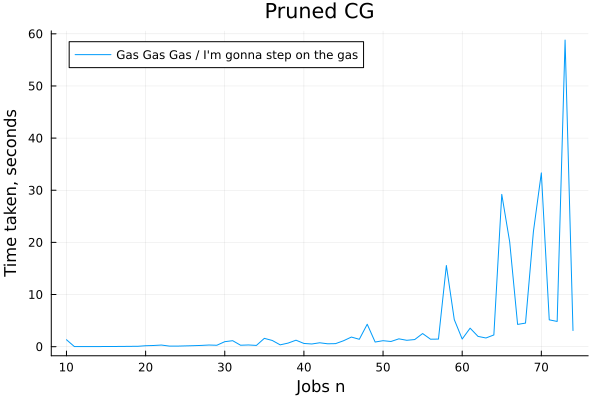

In [220]:
plot([i for i in LOW_JOBS:HIGH_JOBS], times_all, title="Pruned CG", label = "Gas Gas Gas / I'm gonna step on the gas")
xlabel!("Jobs n")
ylabel!("Time taken, seconds")

In [221]:
savefig("pruned-cg-runtime.png")

"/Users/universe/Documents/MIT/UROP/orc/pruned-cg-runtime.png"

In [222]:
times_all[50-10+11]

1.4660003185272217